##### Ultimate Inc. Take Home Challenge
This notebook walks through the solutions for take home challenge by Ultimate Inc.

##### Part 1 - Exploratory Data Analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 8)

In [26]:
# Read in the data
logins = pd.read_json('logins.json')
logins.columns = ['date']
# add a column 'val' with each row value set to 1
# we can group by date and aggregate on 'val' column
logins['val'] = 1
# convert date column to pandas datetime 
logins['date'] = pd.to_datetime(logins['date'])
# set date column as index
logins.set_index('date', inplace=True)
logins.head()



,val
date,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [27]:
# Initial check for data quality: No null values - good!
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
val    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


No NULL values. data looks clean.

In [28]:
def resample(df, interval):
    """
    Takes a dataframe and time interval to resample into
    
    Returns resampled dataframe
    """
    # resample the dataframe 
    temp_resample = df.resample(interval).count()
    return temp_resample

(array([719171., 719185., 719199., 719213., 719227., 719241., 719255.,
        719269.]), <a list of 8 Text xticklabel objects>)

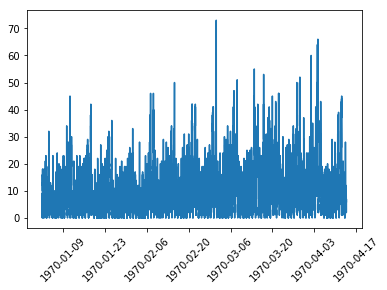

In [29]:
# Show the entire series
plt.plot(logins_df)
plt.xticks(rotation=45)

We see here that we have some series overplotting, but that there are clear areas where there are trends. This is characterized by a darker line on the plot. What we can do now is split the data by month and see if we can more easily find trends.

In [30]:
def custom_plot(df, axis, title, y_label=''):
    """
    Arguments:
    df: A dataframe
    axis: location of subplot
    title: title of subplot
    y_label: y label of subplot
    """
    plt.subplot(axis)
    plt.plot(df['val'])
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()

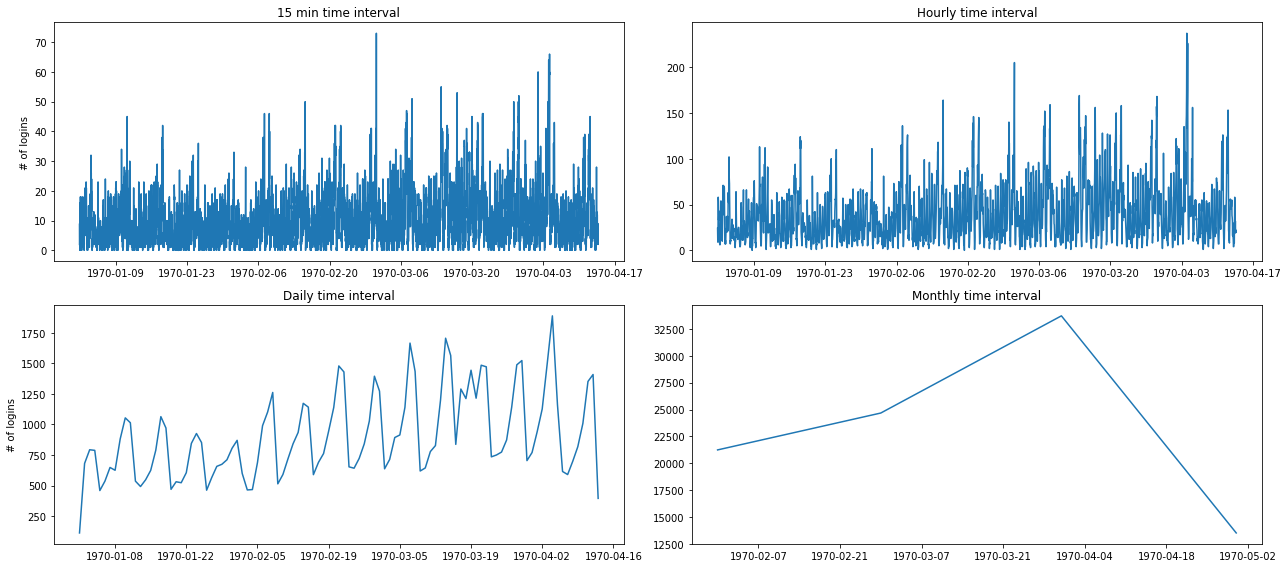

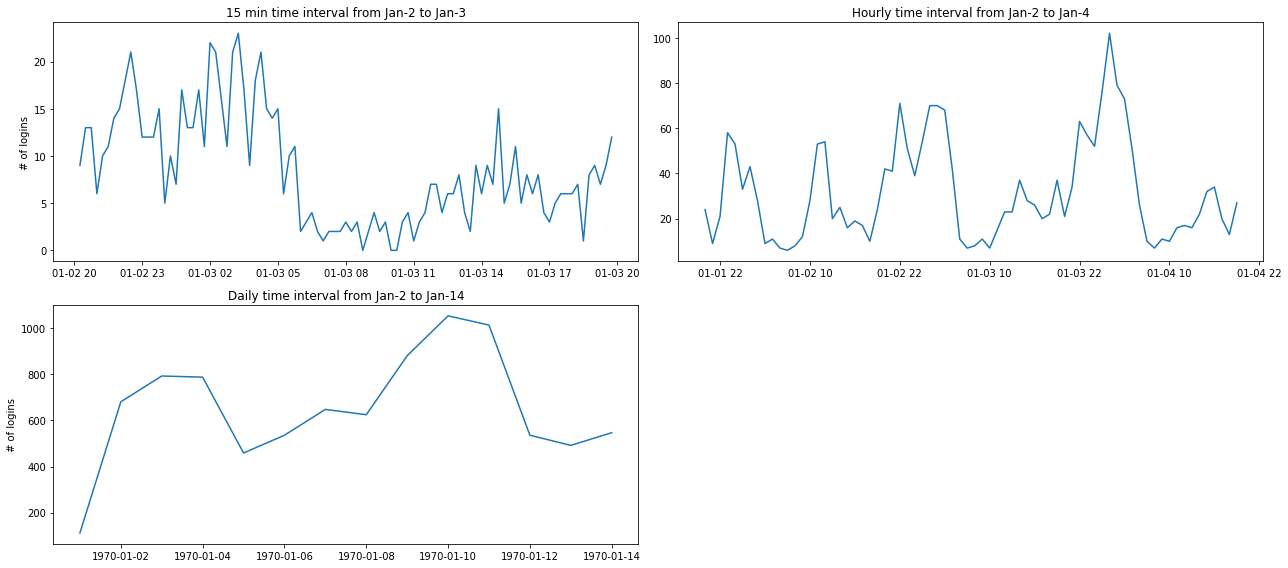

In [35]:

#resampling
min15 = resample(logins, '15Min')
hourly = resample(logins, '60Min')
daily = resample(logins, 'D')
monthly = resample(logins, 'M')

# 15 Min
custom_plot(min15, 221, "15 min time interval", "# of logins")
# Hourly
custom_plot(hourly, 222, "Hourly time interval")
# Daily
custom_plot(daily, 223, "Daily time interval", "# of logins")
# Monthly
custom_plot(monthly, 224, "Monthly time interval")
plt.show()

# 15 Min
custom_plot(min15[97:192], 221, "15 min time interval from Jan-2 to Jan-3", "# of logins")
# Hourly
custom_plot(hourly[:72], 222, "Hourly time interval from Jan-2 to Jan-4")
# Daily
custom_plot(daily[:14], 223, "Daily time interval from Jan-2 to Jan-14", "# of logins")
plt.show()

We can see that there is a trend being followed in the number of logins.
Logins are more during the night compared to day time.
There is an increasing trend from January to April

#### Part 2 - Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the observation
c. how you would interpret the results and provide recommendations to the city operations team along with any caveats

##### Solution
From the given question, it is not stated that there is no toll during the weekends. So, assuming that there is toll 24/7 it could be possible that people are travelling to Metropolis during day to work and returning to Gotham at night. Population in Gotham is more but work is based in Metropolis. Also it is possible that Metropolis is a tourist place but people are not staying there because of costs!!
In contrast to this, during the weekend both the cities are seeing a similar activity as mentioned in the question. The activity could be 1% or 2% compared to weekdays which is not good to compare. So, insufficient information is provided.
However lets consider reimbursing toll costs, then:

I would choose activity as the key measure of success of this experiment because it provides a clear result from the activity. i.e. if people are following the same trends after reimbursing toll, then it is not worth it.
  If the sample size is more than 30, I would choose one sample z-test
Sample should form a single treatment group. In this case people who received reimbursed toll
  Null hypothesis is that there is a difference in driver patterns after reimbursing
Compute z-statistic
find a confidence interval , use the standard normal table to find if the z-stat falls in the confidence interval. Accept or reject the hypothesis

##### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account inJanuary 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice)

#### Data Wrangling

In [39]:
# Read in the data
import json

file = open('ultimate_data_challenge.json', 'r')
data = pd.DataFrame(json.load(file))
file.close()

data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [40]:

# Are there any missing values?# Are th 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


there are few null values in the dataset

In [41]:
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])
data['signup_date'] = pd.to_datetime(data['signup_date'])

In [42]:
data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


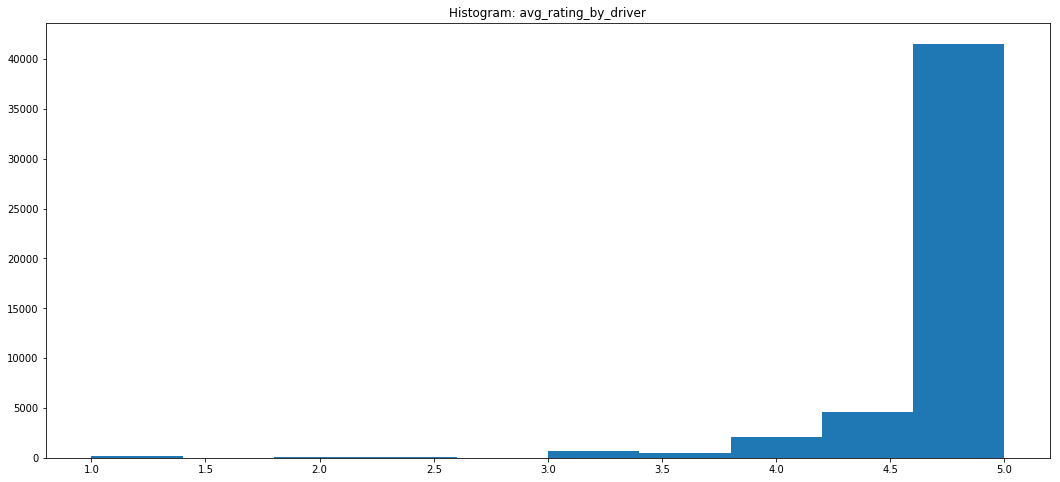

In [46]:
# Let's look at the distribution of values for avg_rating_by_driver

plt.hist(df[np.logical_not(df['avg_rating_by_driver'].isnull())]['avg_rating_by_driver'])
plt.title('Histogram: avg_rating_by_driver')
plt.show;

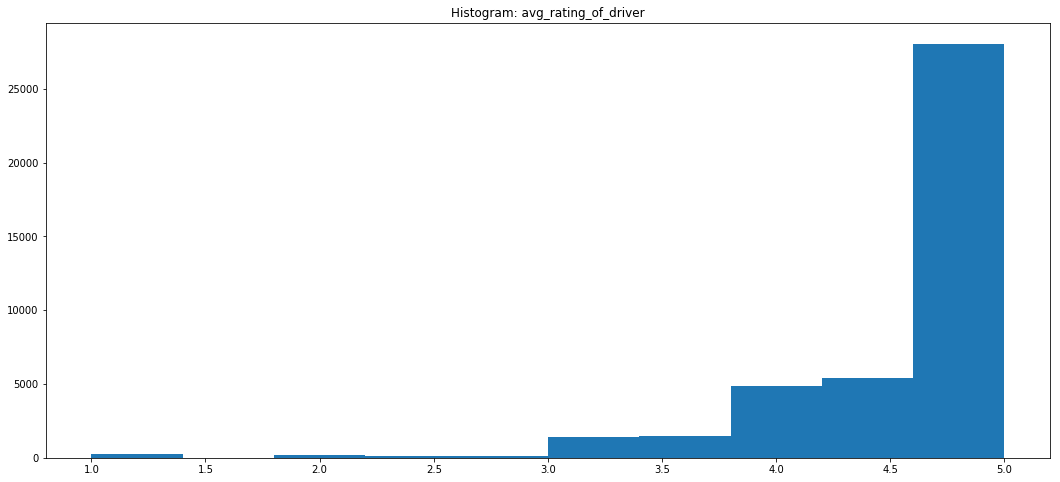

In [47]:
# Let's look at the distribution of values for avg_rating_of_driver

plt.hist(df[np.logical_not(df['avg_rating_of_driver'].isnull())]['avg_rating_of_driver'])
plt.title('Histogram: avg_rating_of_driver')
plt.show;

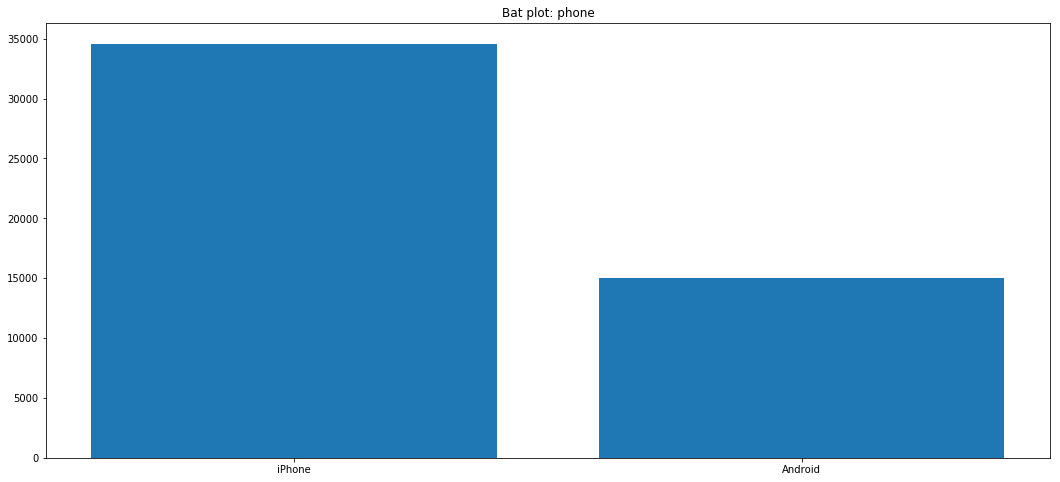

In [48]:
# Let's look at the distribution of values for phone

plt.bar([1,2], df[np.logical_not(df['phone'].isnull())]['phone'].value_counts(), align='center')
plt.xticks([1,2], ['iPhone', 'Android'])
plt.title('Bat plot: phone')
plt.show;

First two plots are highly left skewed so we impute them with mean. In the third plot, most occuring phone is 'iPhone' so we impute null's with 'iPhone'

In [49]:
# Fill in missing values

df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('iPhone', inplace=True)

In [50]:
# Make lists of each feature type for easy plotting

numerical_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                      'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

categorical_features = ['city', 'phone', 'ultimate_black_user']

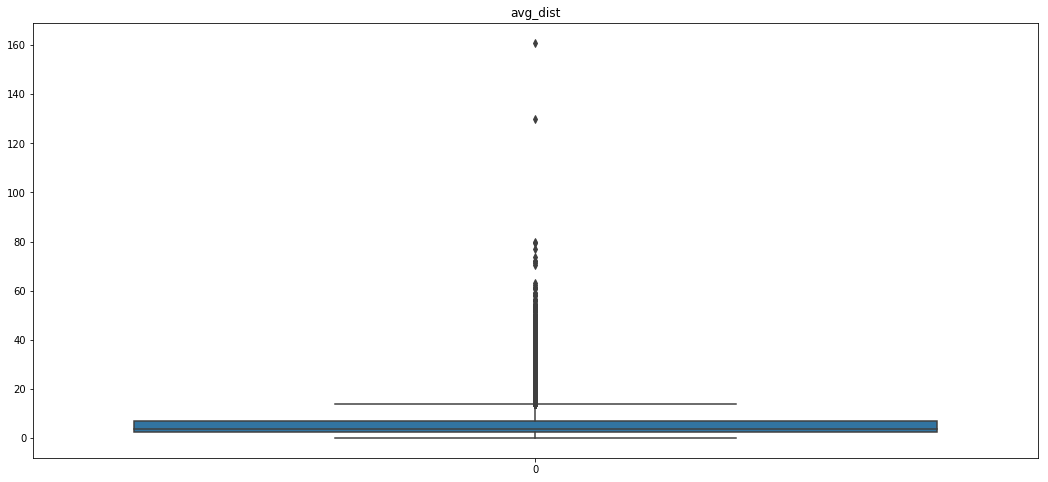

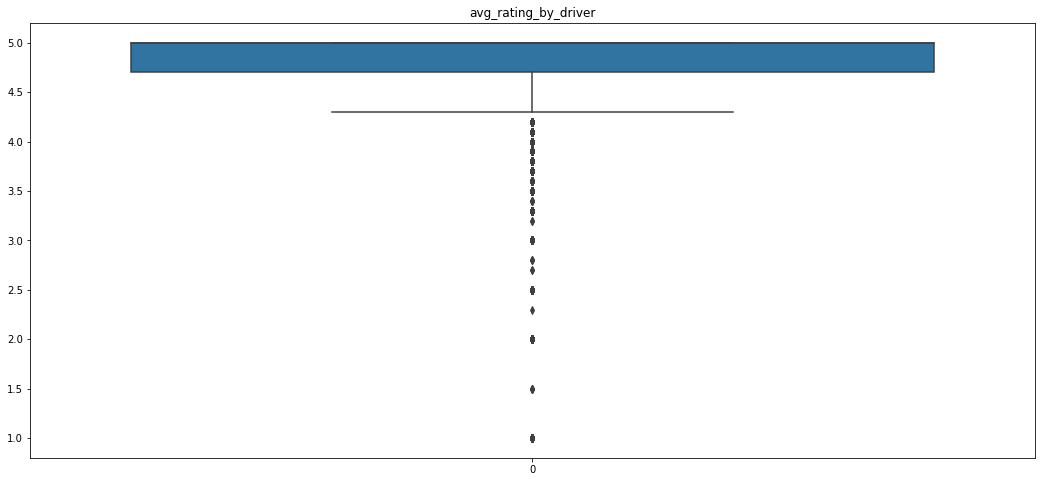

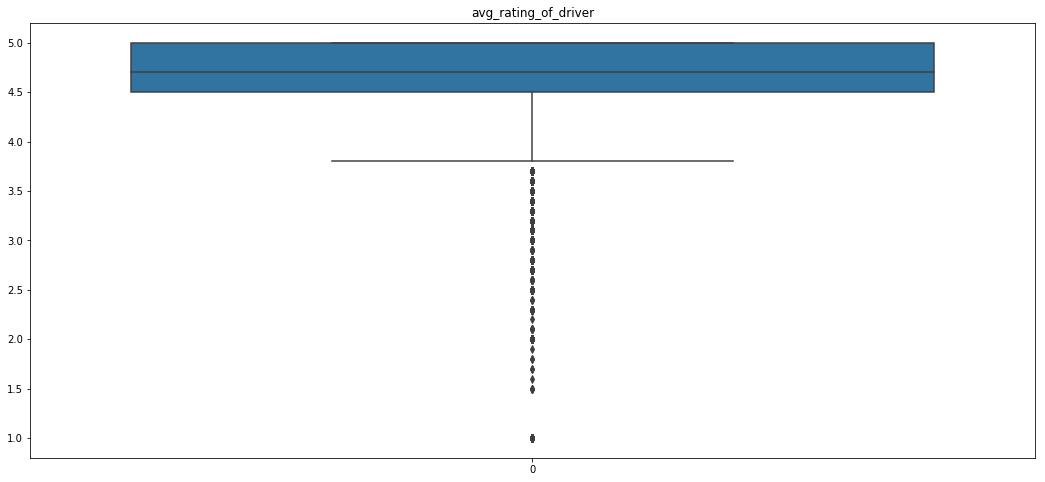

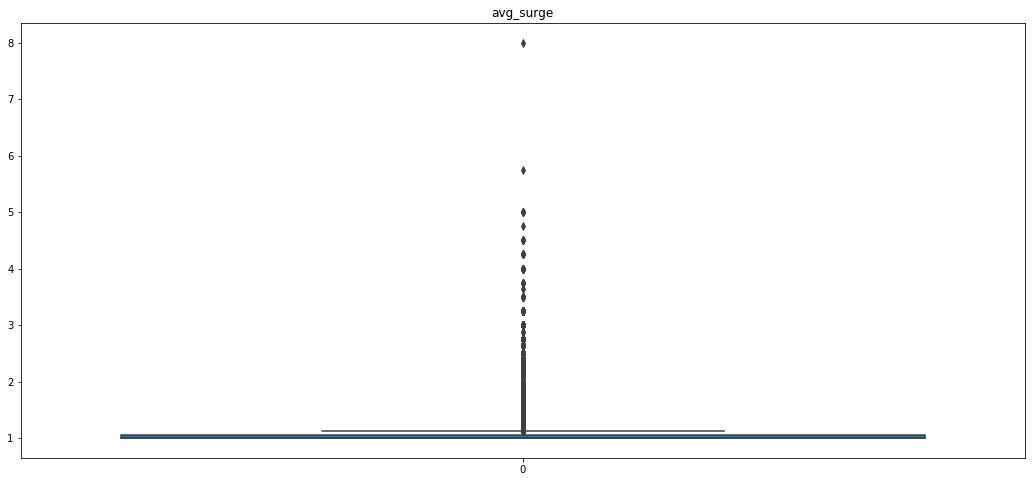

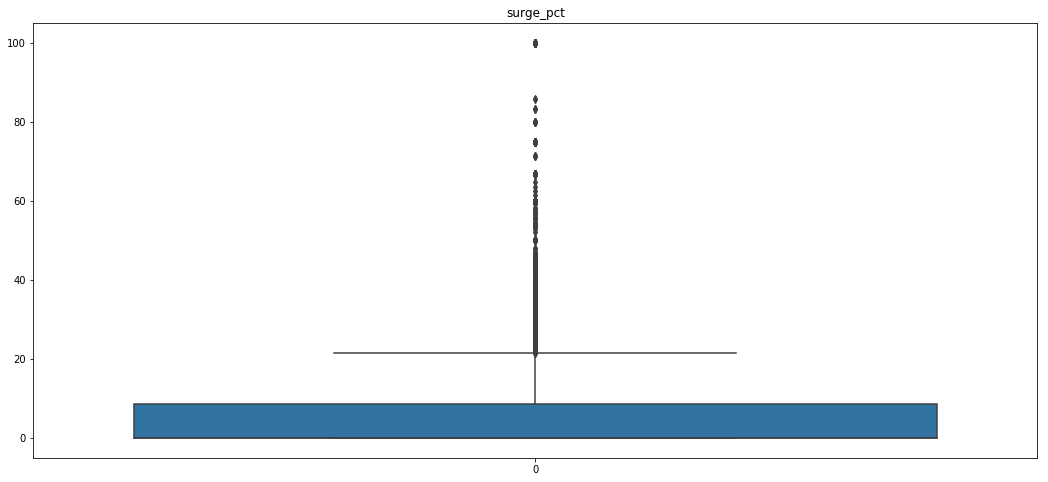

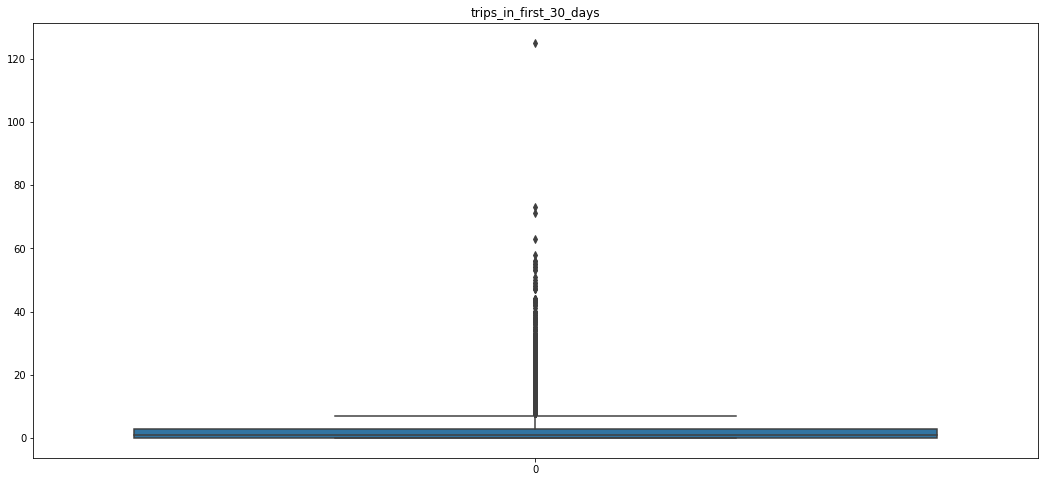

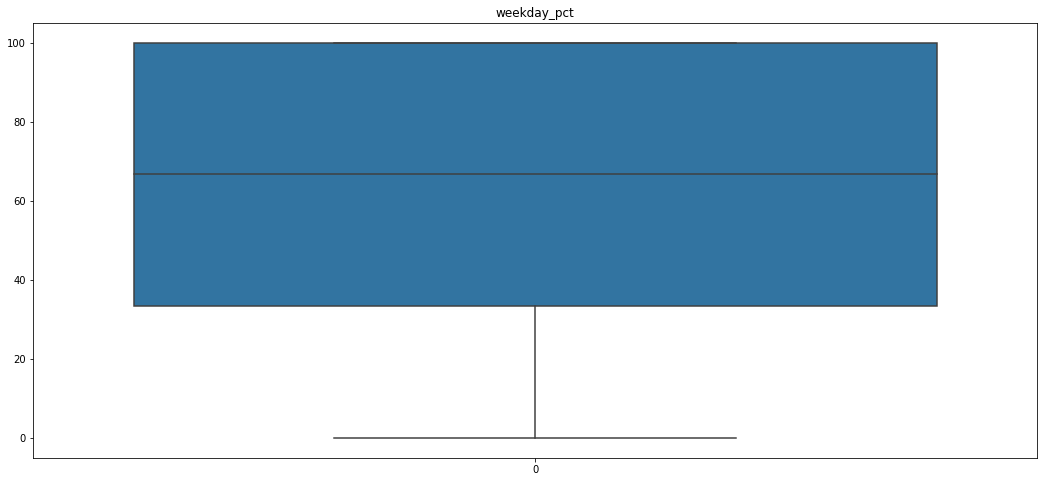

In [52]:
# Show boxplots of numerical features
import seaborn as sns

for feature in numerical_features:
    sns.boxplot(data=df[feature])
    plt.title(feature)
    plt.show();

We can see that there are outliers present in all numerical features except for weekday_pct. We will continue by excluding rows that contain features that take values more than 3 standard deviations away from the mean.

In [55]:
# Filter out rows with features that have values more than 3 standard deviations from the mean
for feature in numerical_features:
    llimit=df[feature].mean() - 3 * df[feature].std()
    ulimit=df[feature].mean() + 3 * df[feature].std()
    df=df[ df[feature] >= llimit ]
    df=df[ df[feature] <= ulimit]
df.reset_index(drop=True, inplace=True)

In [56]:
# How much data do we have now?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 12 columns):
avg_dist                  44666 non-null float64
avg_rating_by_driver      44666 non-null float64
avg_rating_of_driver      44666 non-null float64
avg_surge                 44666 non-null float64
city                      44666 non-null object
last_trip_date            44666 non-null object
phone                     44666 non-null object
signup_date               44666 non-null object
surge_pct                 44666 non-null float64
trips_in_first_30_days    44666 non-null int64
ultimate_black_user       44666 non-null bool
weekday_pct               44666 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


In [58]:
# Show the correlation matrix
corr_matrix = df.corr()
corr_matrix

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,1.000000,0.113764,0.036985,-0.125715,-0.141120,-0.157064,0.032364,0.106505
avg_rating_by_driver,0.113764,1.000000,0.108811,-0.054707,-0.045886,-0.136598,-0.020618,0.019580
avg_rating_of_driver,0.036985,0.108811,1.000000,-0.030831,-0.012833,-0.058875,-0.011233,0.004661
avg_surge,-0.125715,-0.054707,-0.030831,1.000000,0.849852,0.150471,-0.016889,-0.091408
surge_pct,-0.141120,-0.045886,-0.012833,0.849852,1.000000,0.145407,-0.035394,-0.103303
trips_in_first_30_days,-0.157064,-0.136598,-0.058875,0.150471,0.145407,1.000000,0.082045,0.025849
ultimate_black_user,0.032364,-0.020618,-0.011233,-0.016889,-0.035394,0.082045,1.000000,0.021997
weekday_pct,0.106505,0.019580,0.004661,-0.091408,-0.103303,0.025849,0.021997,1.000000


In [59]:
# Filter to see if there are any features correlated at above 0.50 or below -0.50
corr_matrix[(abs(corr_matrix) >= 0.50) & (abs(corr_matrix) < 1.0)]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_by_driver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_of_driver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_surge,NaN,NaN,NaN,NaN,0.849852,NaN,NaN,NaN
surge_pct,NaN,NaN,NaN,0.849852,NaN,NaN,NaN,NaN
trips_in_first_30_days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ultimate_black_user,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that surge_pct and avg_surge are highly correlated with eachother at 0.849852, and this makes sense given these two features are highly related to there being a surge or not. Since there are not too many features in this dataset, we will keep these two features.

##### What fraction of the observed users were retained?

In [60]:
# When was the last trip date in the dataset?
sorted(df['last_trip_date'].unique())[-10:]

['2014-06-22',
 '2014-06-23',
 '2014-06-24',
 '2014-06-25',
 '2014-06-26',
 '2014-06-27',
 '2014-06-28',
 '2014-06-29',
 '2014-06-30',
 '2014-07-01']

Based on the last trip date in the dataset of 7/1/2014, it looks like the data was pulled on July 1st, 2014. By definition, retained users made a trip within the last 30 days of this date. Let's see how many users have been retained:

In [62]:
# Percentage of users retained after june 2014
len(df[df['last_trip_date'] >= '2014-06-01'])/len(df)*100

38.58639681189271

#### Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance

In [64]:
# Create the target variable, retained

df['retained'] = np.nan
df.loc[df['last_trip_date'] >= '2014-06-01', 'retained'] = 1
df.loc[df['last_trip_date'] < '2014-06-01', 'retained'] = 0
# Drop last_trip_date
df.drop('last_trip_date', axis=1, inplace=True)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,2014-01-25,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,Android,2014-01-29,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,2014-01-06,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,2014-01-10,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,Android,2014-01-27,11.8,14,False,82.4,0.0


Since most models don't handle character data, we have to convert them to numeric

In [65]:
# Drop other datetime features
df.drop('signup_date', axis=1, inplace=True)

In [66]:

# One-hot-encode all categorical features# One-ho 
df = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1.0,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0.0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1.0,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0.0,0,0,1,1,0,1,0


In [71]:
# Get the Dependent and Independent Features.
X = df.drop(['retained'], axis=1)
y = df['retained']

In [72]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Since the Random forest bring randomness to the model, It can be easily used for this prediction. Model accuracy can be increased using hyperparameter tuning.

In [73]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [75]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 40.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [76]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [79]:
best_random_predictions = rf_random.best_estimator_.predict(X_test)
best_random_accuracy = accuracy_score(y_test, best_random_predictions)
print("Accuracy: %.2f%%" % (best_random_accuracy * 100.0))

Accuracy: 77.35%


We now have a model that is about 77% accurate and does a fairly good job of determining the difference between a retained and not retained users

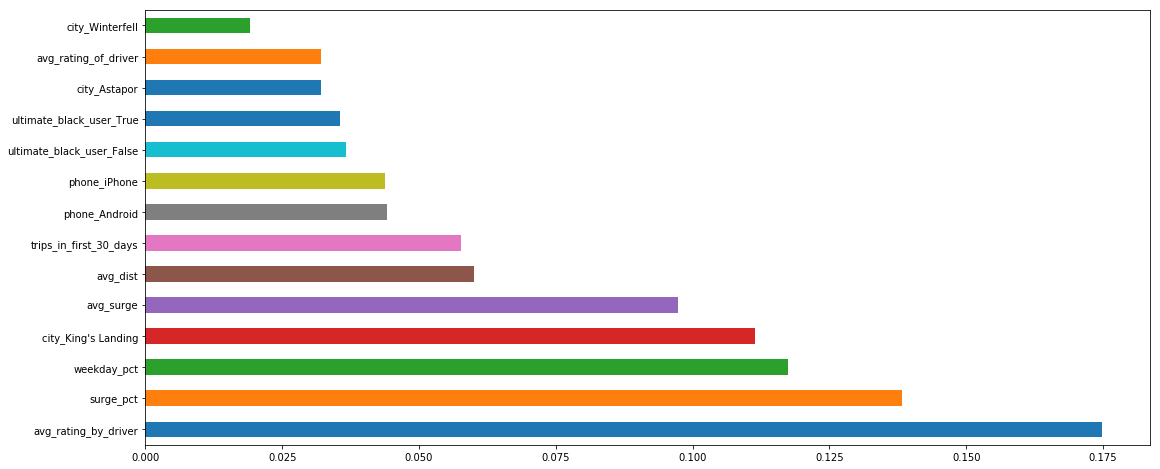

In [85]:
#we can see which are features that influenced the most in prediction 
feat_importances = pd.Series(rf_random.best_estimator_.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.show()

The top 3 most predictive features, from most to least, are avg_rating_by_driver, surge_pct, and weekday_pct.

###### Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

To improve longterm rider retention, Ultimate might want to focus on the top predictors of model performance:

avg_rating_by_driver, surge_pct, and weekday_pct in first 30 days determine user retention
Improving the customer service can lead to good results
Improving interface on devices and accessibility in the cities could also lead to user retention